# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 18:59:39.405460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 18:59:39.405555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 18:59:39.540021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-6, who has ID: A288D2R9WAJBZS

In [2]:
parameters = {}

user = "users-6"
user_id = "A288D2R9WAJBZS"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,APFEB2OQRCTWM,B00025K10W,B000QJETYS,B003ZYF1R0
1,A24REJO42DE368,B00025K10W,B00D5AOC2O,B00BRXP8LA
2,A3TFU7Q20D66LF,B00025K10W,B0180A1CWG,B00ZASGV78
3,A3E99CV86WDAJ9,B00025K10W,B0029NMQO4,B0002ARYWU
4,A303WJA0WDZDW6,B00025K10W,B013TKCZZK,B00K0PQII8
...,...,...,...,...
42645,AMOIPX2IFKR03,B01DQQDMKO,B01BPCLKDM,B015G31EGE
42646,A1QUYU9SVCJJFK,B01DQQDMKO,B01GJJHPLC,B01GU6YW60
42647,A1QBFOFQTTD9VV,B01GQHMRRY,B001W2NMGY,B00X4SAP82
42648,AMHN9S332K3G0,B01GQHMRRY,B0022KCNPQ,B00CKFL93K


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 42650
Number of sequences and targets after removal: 41969


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A288D2R9WAJBZS
productID                 B00VDYDR0M
purchased_before_1        B01B5KJ1FS
purchased_before_2        B00A755SKA
Name: 404, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 41968
Number of sequences and targets after dropping duplicates: 33871


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 124
Number of unique product IDs in sequences: 19501


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B000QJETYS', 'B003ZYF1R0'],
        ['B00D5AOC2O', 'B00BRXP8LA'],
        ['B0180A1CWG', 'B00ZASGV78'],
        ['B0029NMQO4', 'B0002ARYWU'],
        ['B013TKCZZK', 'B00K0PQII8'],
        ['B00C9US5KG', 'B000UGB9EA'],
        ['B000W5QSYA', 'B000W5QSYA'],
        ['B00BQ1L6LO', 'B011QCYRWC'],
        ['B001EUE4HK', 'B00BD7WE30'],
        ['B006VGI3WE', 'B00JYIOXKW']], dtype=object),
 array(['B00025K10W', 'B00025K10W', 'B00025K10W', 'B00025K10W',
        'B00025K10W', 'B00025K10W', 'B00025K10W', 'B00025K10W',
        'B00025K10W', 'B000OX89XI'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[16273, 36191],
        [74871, 69995],
        [129649, 118854],
        [29722, 2839],
        [123286, 93045],
        [71864, 17244],
        [17914, 17914],
        [69878, 121345],
        [24315, 68524],
        [53471, 92899]], dtype=object),
 array([1182, 1182, 1182, 1182, 1182, 1182, 1182, 1182, 1182, 15738],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 27082
Number of validation sequences: 3393
Number of test sequences: 3396

Number of train targets: 27082
Number of validation targets: 3393
Number of test targets: 3396

Number of classes (unique product IDs) in the train targets: 114
Number of classes in the validation targets: 117
Number of classes in the test targets: 124


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([18274, 18274], dtype=object),
 array([6137, 11017], dtype=object),
 array([7617, 7632], dtype=object),
 array([74871, 69995], dtype=object),
 array([29430, 22923], dtype=object),
 array([94365, 118485], dtype=object),
 array([54568, 2710], dtype=object),
 array([16138, 42078], dtype=object),
 array([70005, 77163], dtype=object),
 array([15775, 12228], dtype=object)]

In [19]:
y_train[:10]

[1182, 1182, 1182, 1182, 1182, 1182, 1182, 1182, 1182, 1182]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 18/847 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0747 - f1_score: 0.0607 - f1_score_at_k: 0.1339 - hit_rate_at_k: 0.3303 - loss: 11.8505 - ndcg_at_k: 0.0683                       

I0000 00:00:1714590002.978565     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


847/847 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.1820 - f1_score: 0.0872 - f1_score_at_k: 0.1652 - hit_rate_at_k: 0.5388 - loss: 7.1047 - ndcg_at_k: 0.1226 - val_accuracy: 0.1217 - val_f1_score: 0.1235 - val_f1_score_at_k: 0.3390 - val_hit_rate_at_k: 0.3341 - val_loss: 3.6311 - val_ndcg_at_k: 0.0782
Epoch 2/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2028 - f1_score: 0.1117 - f1_score_at_k: 0.2001 - hit_rate_at_k: 0.5707 - loss: 2.9769 - ndcg_at_k: 0.1317 - val_accuracy: 0.1373 - val_f1_score: 0.1615 - val_f1_score_at_k: 0.3911 - val_hit_rate_at_k: 0.3747 - val_loss: 3.5370 - val_ndcg_at_k: 0.0878
Epoch 3/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2192 - f1_score: 0.1478 - f1_score_at_k: 0.2232 - hit_rate_at_k: 0.5846 - loss: 2.8801 - ndcg_at_k: 0.1380 - val_accuracy: 0.1515 - val_f1_score: 0.1848 - val_f1_score_at_k: 0.4539 - val_hit_rate_at_k: 0.3981 - val_loss: 3.4943 - val_ndcg_at_k: 0.0959
Epoch 4/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - a

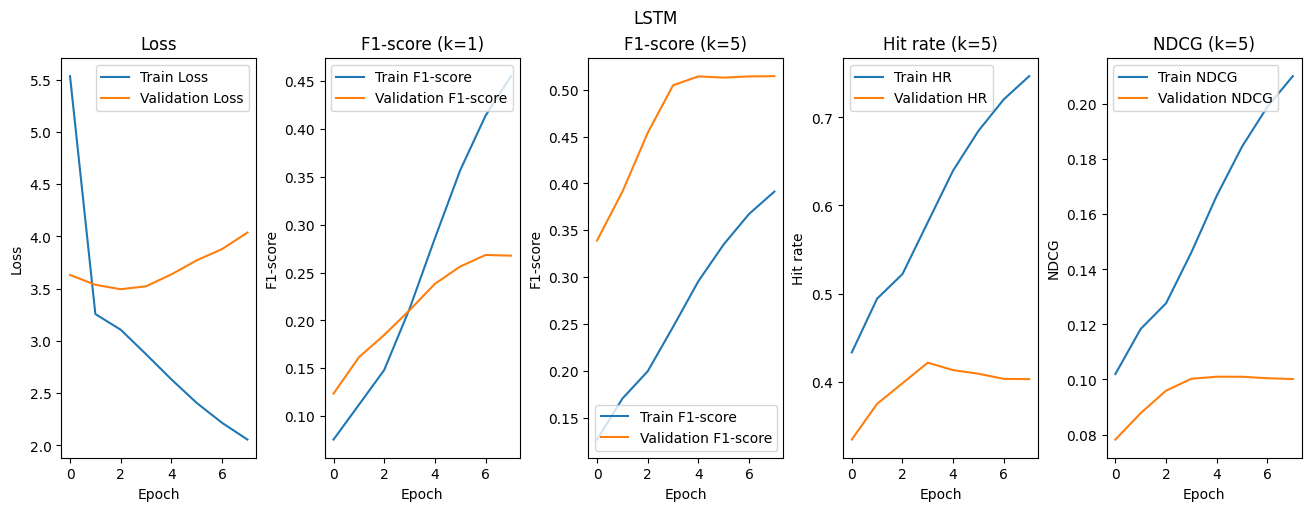

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1408 - f1_score: 0.2145 - f1_score_at_k: 0.4880 - hit_rate_at_k: 0.3715 - loss: 4.0643 - ndcg_at_k: 0.0866            
Test loss: 4.0994
Test accuracy: 0.1731
Test F1@1: 0.2552
Test F1@5: 0.504
Test HR@5: 0.3978
Test NDCG@5: 0.0977


In [32]:
parameters

{'user': 'users-6',
 'user_id': 'A288D2R9WAJBZS',
 'number_of_sequences_and_targets_before_removal': 42650,
 'number_of_sequences_and_targets_after_removal': 41969,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 33871,
 'num_unique_product_ids_in_targets': 124,
 'num_unique_product_ids_in_sequences': 19501,
 'number_of_sequences_and_targets_train': 27082,
 'number_of_sequences_and_targets_validation': 3393,
 'number_of_sequences_and_targets_test': 3396,
 'number_of_unique_products_in_targets_train': 114,
 'number_of_unique_products_in_targets_validation': 117,
 'number_of_unique_products_in_targets_test': 124,
 'model_lstm_test_loss': 4.09942626953125,
 'model_lstm_test_accuracy': 0.1731,
 'model_lstm_test_f1_score_k_1': 0.2552,
 'model_lstm_test_f1_score_k_5': 0.504,
 'model_lstm_test_hr': 0.3978,
 'model_lstm_test_ndcg': 0.0977}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.1801 - f1_score: 0.0878 - f1_score_at_k: 0.1677 - hit_rate_at_k: 0.5494 - loss: 6.6505 - ndcg_at_k: 0.1238 - val_accuracy: 0.1200 - val_f1_score: 0.1235 - val_f1_score_at_k: 0.3845 - val_hit_rate_at_k: 0.3674 - val_loss: 3.5784 - val_ndcg_at_k: 0.0842
Epoch 2/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2083 - f1_score: 0.1291 - f1_score_at_k: 0.2077 - hit_rate_at_k: 0.5739 - loss: 2.9360 - ndcg_at_k: 0.1338 - val_accuracy: 0.1559 - val_f1_score: 0.1868 - val_f1_score_at_k: 0.4081 - val_hit_rate_at_k: 0.3703 - val_loss: 3.5035 - val_ndcg_at_k: 0.0902
Epoch 3/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2530 - f1_score: 0.1915 - f1_score_at_k: 0.2471 - hit_rate_at_k: 0.6120 - loss: 2.7523 - ndcg_at_k: 0.1476 - val_accuracy: 0.1577 - val_f1_score: 0.2125 - val_f1_score_at_k: 0.4506 - val_hit_rate_at_k: 0.3768 - val_loss: 3.5116 - val_ndcg_at_k: 0.0924
Epoch 4/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 8

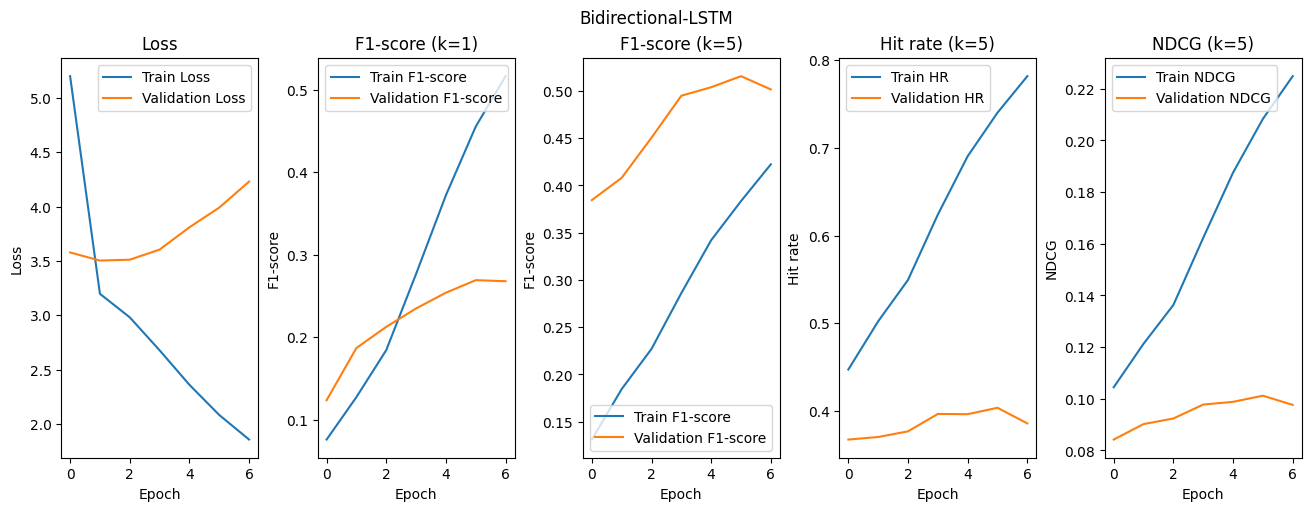

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1500 - f1_score: 0.2313 - f1_score_at_k: 0.4802 - hit_rate_at_k: 0.3588 - loss: 4.1966 - ndcg_at_k: 0.0867
Test loss: 4.2975
Test accuracy: 0.1749
Test F1@1: 0.2598
Test F1@5: 0.4915
Test HR@5: 0.3803
Test NDCG@5: 0.0954


In [37]:
parameters

{'user': 'users-6',
 'user_id': 'A288D2R9WAJBZS',
 'number_of_sequences_and_targets_before_removal': 42650,
 'number_of_sequences_and_targets_after_removal': 41969,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 33871,
 'num_unique_product_ids_in_targets': 124,
 'num_unique_product_ids_in_sequences': 19501,
 'number_of_sequences_and_targets_train': 27082,
 'number_of_sequences_and_targets_validation': 3393,
 'number_of_sequences_and_targets_test': 3396,
 'number_of_unique_products_in_targets_train': 114,
 'number_of_unique_products_in_targets_validation': 117,
 'number_of_unique_products_in_targets_test': 124,
 'model_lstm_test_loss': 4.09942626953125,
 'model_lstm_test_accuracy': 0.1731,
 'model_lstm_test_f1_score_k_1': 0.2552,
 'model_lstm_test_f1_score_k_5': 0.504,
 'model_lstm_test_hr': 0.3978,
 'model_lstm_test_ndcg': 0.0977,
 'model_bi_lstm_test_loss': 4.297487735748291,
 'model_bi_lstm_test_accuracy': 0.1749,
 'model_bi_lstm_test_f1_score_k_1': 0.25

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.1876 - f1_score: 0.0945 - f1_score_at_k: 0.1742 - hit_rate_at_k: 0.5524 - loss: 7.0921 - ndcg_at_k: 0.1259 - val_accuracy: 0.1323 - val_f1_score: 0.1458 - val_f1_score_at_k: 0.3838 - val_hit_rate_at_k: 0.3695 - val_loss: 3.5597 - val_ndcg_at_k: 0.0869
Epoch 2/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2028 - f1_score: 0.1276 - f1_score_at_k: 0.2145 - hit_rate_at_k: 0.5794 - loss: 2.9564 - ndcg_at_k: 0.1339 - val_accuracy: 0.1477 - val_f1_score: 0.1712 - val_f1_score_at_k: 0.4216 - val_hit_rate_at_k: 0.3876 - val_loss: 3.5145 - val_ndcg_at_k: 0.0915
Epoch 3/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2456 - f1_score: 0.1911 - f1_score_at_k: 0.2412 - hit_rate_at_k: 0.6126 - loss: 2.8260 - ndcg_at_k: 0.1470 - val_accuracy: 0.1565 - val_f1_score: 0.1971 - val_f1_score_at_k: 0.4652 - val_hit_rate_at_k: 0.4004 - val_loss: 3.4907 - val_ndcg_at_k: 0.0952
Epoch 4/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7

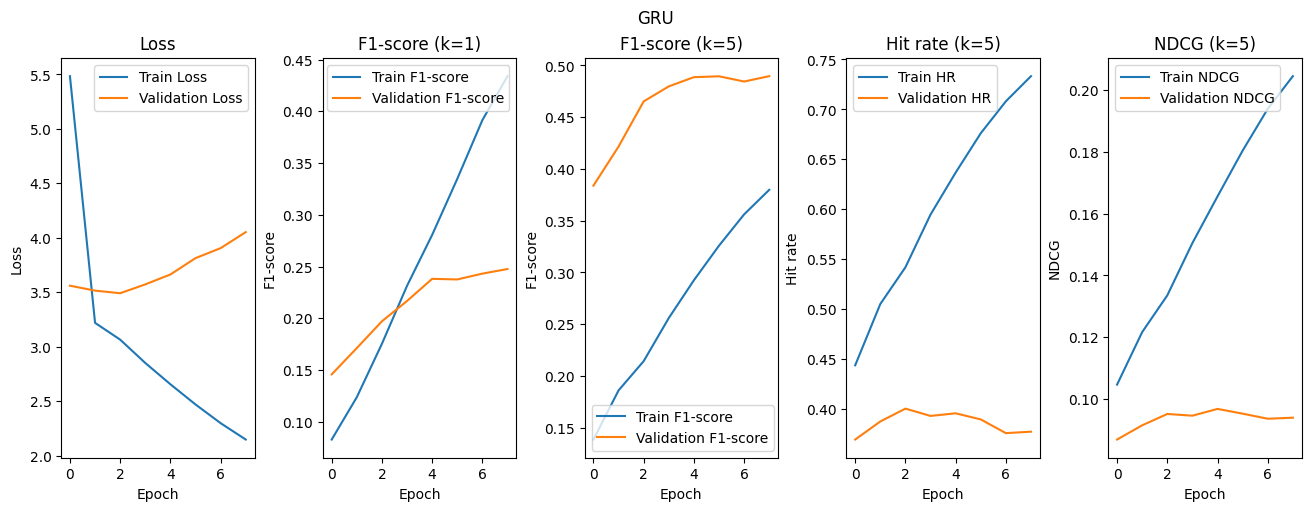

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1186 - f1_score: 0.1811 - f1_score_at_k: 0.4514 - hit_rate_at_k: 0.3372 - loss: 4.1130 - ndcg_at_k: 0.0761            
Test loss: 4.1131
Test accuracy: 0.1575
Test F1@1: 0.2321
Test F1@5: 0.4809
Test HR@5: 0.3759
Test NDCG@5: 0.0913


In [42]:
parameters

{'user': 'users-6',
 'user_id': 'A288D2R9WAJBZS',
 'number_of_sequences_and_targets_before_removal': 42650,
 'number_of_sequences_and_targets_after_removal': 41969,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 33871,
 'num_unique_product_ids_in_targets': 124,
 'num_unique_product_ids_in_sequences': 19501,
 'number_of_sequences_and_targets_train': 27082,
 'number_of_sequences_and_targets_validation': 3393,
 'number_of_sequences_and_targets_test': 3396,
 'number_of_unique_products_in_targets_train': 114,
 'number_of_unique_products_in_targets_validation': 117,
 'number_of_unique_products_in_targets_test': 124,
 'model_lstm_test_loss': 4.09942626953125,
 'model_lstm_test_accuracy': 0.1731,
 'model_lstm_test_f1_score_k_1': 0.2552,
 'model_lstm_test_f1_score_k_5': 0.504,
 'model_lstm_test_hr': 0.3978,
 'model_lstm_test_ndcg': 0.0977,
 'model_bi_lstm_test_loss': 4.297487735748291,
 'model_bi_lstm_test_accuracy': 0.1749,
 'model_bi_lstm_test_f1_score_k_1': 0.25

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.1390 - f1_score: 0.1039 - f1_score_at_k: 0.1666 - hit_rate_at_k: 0.3583 - loss: 8.8514 - ndcg_at_k: 0.0843 - val_accuracy: 0.1291 - val_f1_score: 0.1456 - val_f1_score_at_k: 0.4099 - val_hit_rate_at_k: 0.3879 - val_loss: 3.6178 - val_ndcg_at_k: 0.0882
Epoch 2/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1979 - f1_score: 0.1208 - f1_score_at_k: 0.2006 - hit_rate_at_k: 0.5490 - loss: 3.0679 - ndcg_at_k: 0.1276 - val_accuracy: 0.1435 - val_f1_score: 0.1665 - val_f1_score_at_k: 0.4084 - val_hit_rate_at_k: 0.3905 - val_loss: 3.5381 - val_ndcg_at_k: 0.0917
Epoch 3/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2065 - f1_score: 0.1366 - f1_score_at_k: 0.2055 - hit_rate_at_k: 0.5591 - loss: 3.0354 - ndcg_at_k: 0.1302 - val_accuracy: 0.1465 - val_f1_score: 0.1716 - val_f1_score_at_k: 0.3975 - val_hit_rate_at_k: 0.3732 - val_loss: 3.5295 - val_ndcg_at_k: 0.0885
Epoch 4/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7

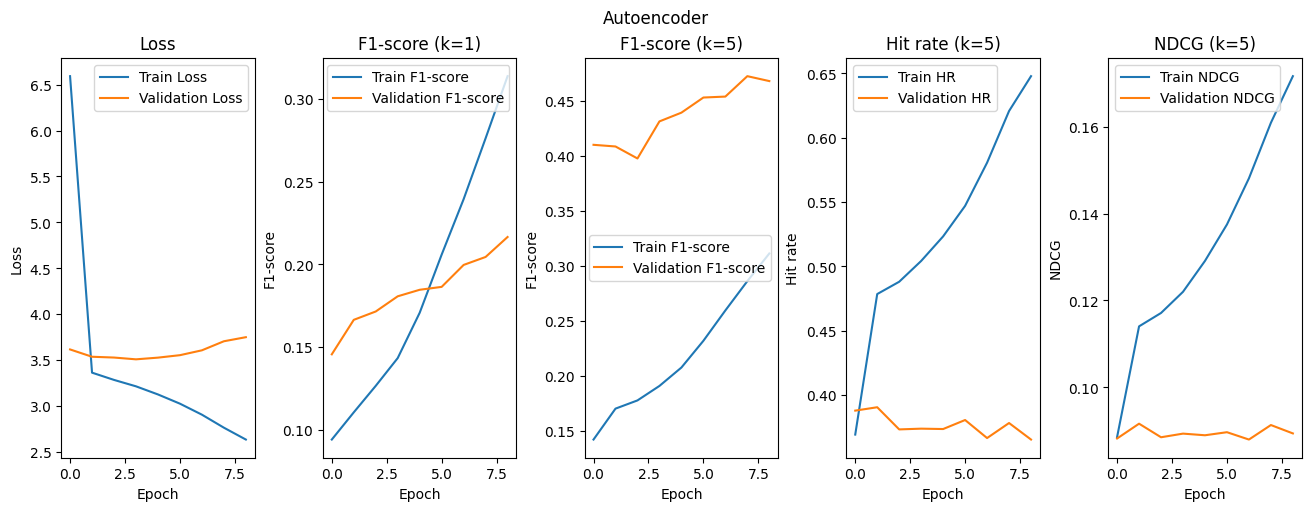

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0897 - f1_score: 0.1320 - f1_score_at_k: 0.4472 - hit_rate_at_k: 0.3319 - loss: 3.8201 - ndcg_at_k: 0.0720            
Test loss: 3.8108
Test accuracy: 0.1458
Test F1@1: 0.2035
Test F1@5: 0.4591
Test HR@5: 0.3557
Test NDCG@5: 0.0863


In [47]:
parameters

{'user': 'users-6',
 'user_id': 'A288D2R9WAJBZS',
 'number_of_sequences_and_targets_before_removal': 42650,
 'number_of_sequences_and_targets_after_removal': 41969,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 33871,
 'num_unique_product_ids_in_targets': 124,
 'num_unique_product_ids_in_sequences': 19501,
 'number_of_sequences_and_targets_train': 27082,
 'number_of_sequences_and_targets_validation': 3393,
 'number_of_sequences_and_targets_test': 3396,
 'number_of_unique_products_in_targets_train': 114,
 'number_of_unique_products_in_targets_validation': 117,
 'number_of_unique_products_in_targets_test': 124,
 'model_lstm_test_loss': 4.09942626953125,
 'model_lstm_test_accuracy': 0.1731,
 'model_lstm_test_f1_score_k_1': 0.2552,
 'model_lstm_test_f1_score_k_5': 0.504,
 'model_lstm_test_hr': 0.3978,
 'model_lstm_test_ndcg': 0.0977,
 'model_bi_lstm_test_loss': 4.297487735748291,
 'model_bi_lstm_test_accuracy': 0.1749,
 'model_bi_lstm_test_f1_score_k_1': 0.25

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A288D2R9WAJBZS', 'sequence': [133793, 64461], 'target': 113817}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 0.0
NDCG@50: 0.0
-------------
HT@100: 0.0
NDCG@100: 0.0
-------------
HT@200: 0.0
NDCG@200: 0.0
-------------
HT@300: 0.0
NDCG@300: 0.0
-------------
HT@400: 0.0
NDCG@400: 0.0
-------------
HT@500: 0.0
NDCG@500: 0.0
-------------
